In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

###**EDA**

In [2]:
file_path = "/content/hospital_readmissions.csv"
df = pd.read_csv(file_path)

df_info = df.info()
df_head = df.head()
df_shape = df.shape

df_info, df_head, df_shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

(None,
        age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
 0  [70-80)                 8                72             1             18   
 1  [70-80)                 3                34             2             13   
 2  [50-60)                 5                45             0             18   
 3  [70-80)                 2                36             0             12   
 4  [60-70)                 1                42             0              7   
 
    n_outpatient  n_inpatient  n_emergency medical_specialty       diag_1  \
 0             2            0            0           Missing  Circulatory   
 1             0            0            0             Other        Other   
 2             0            0            0           Missing  Circulatory   
 3             1            0            0           Missing  Circulatory   
 4             0            0            0  InternalMedicine        Other   
 
         diag_2       diag_3 glucose_test A1Cte

Data Cleaning

In [3]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
             '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
df['age'] = pd.Categorical(df['age'], categories=age_order, ordered=True)


missing values

In [4]:
missing_values = df.isnull().sum()
missing_values

,0
age,0
time_in_hospital,0
n_lab_procedures,0
n_procedures,0
n_medications,0
n_outpatient,0
n_inpatient,0
n_emergency,0
medical_specialty,0
diag_1,0


Univariate Analysis

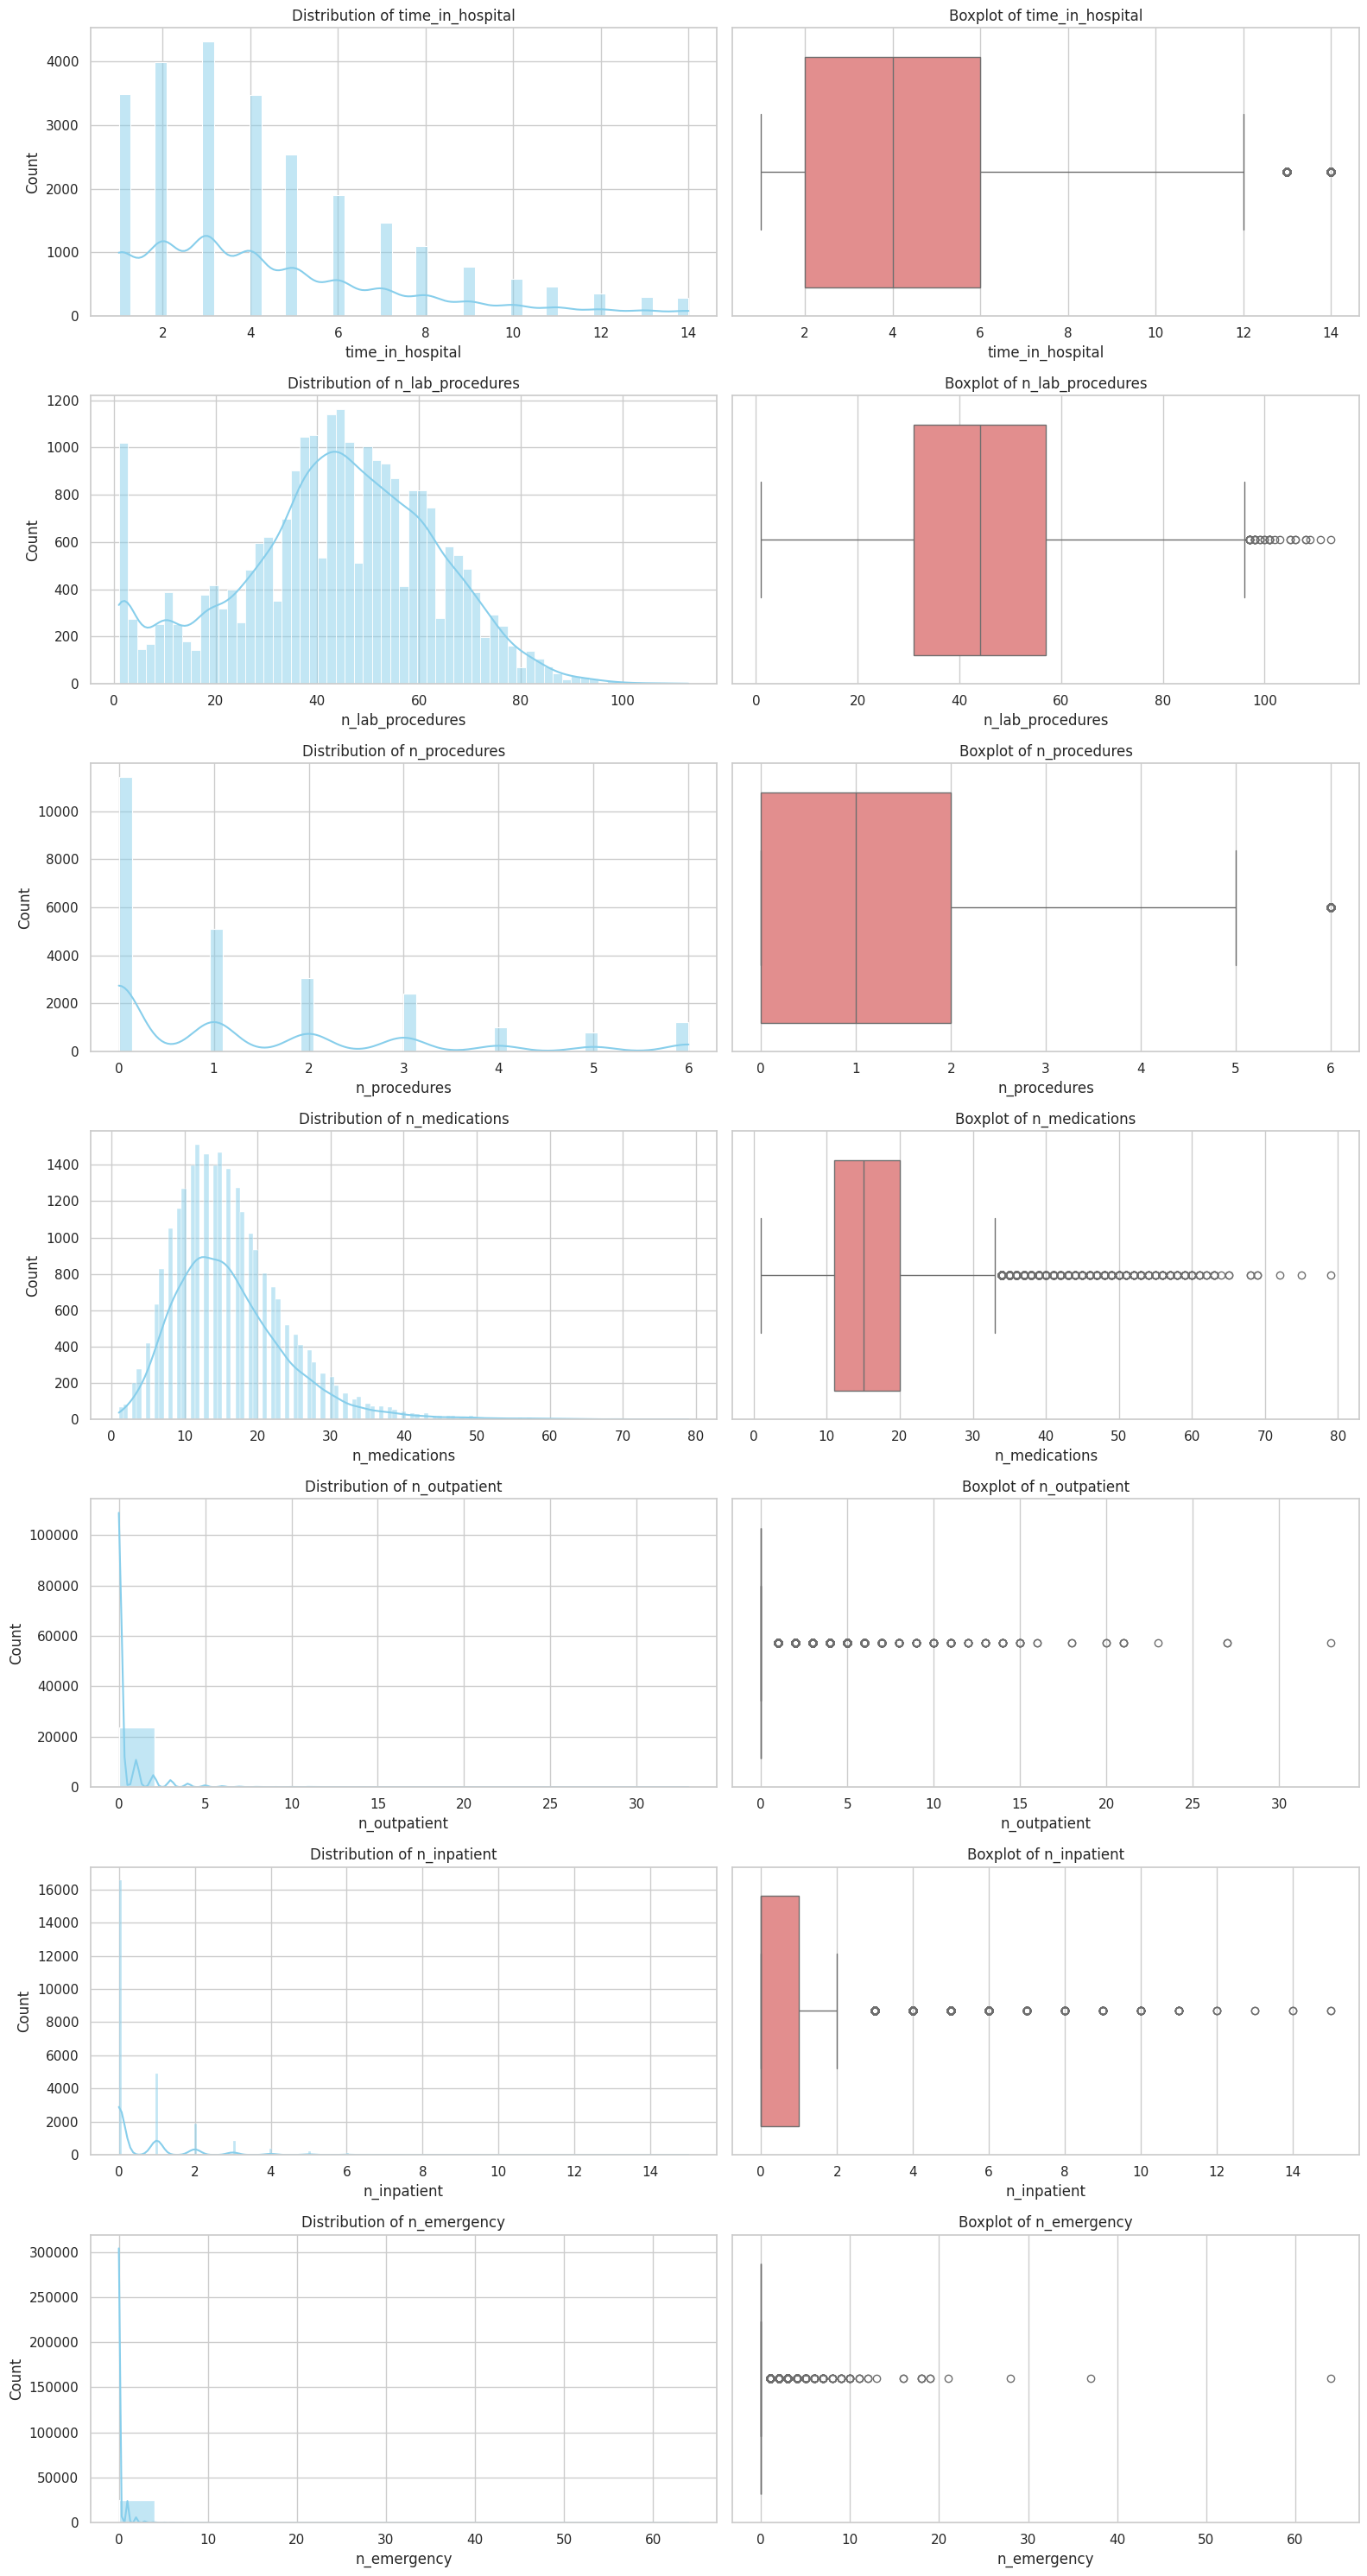

In [5]:
# Distribution plots for numerical features
numerical_cols = ['time_in_hospital', 'n_lab_procedures', 'n_procedures',
                  'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']

fig, axs = plt.subplots(len(numerical_cols), 2, figsize=(16, 30))
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axs[i, 0], color='skyblue')
    axs[i, 0].set_title(f"Distribution of {col}")
    sns.boxplot(x=df[col], ax=axs[i, 1], color='lightcoral')
    axs[i, 1].set_title(f"Boxplot of {col}")
plt.tight_layout()

Bivariate Analysis

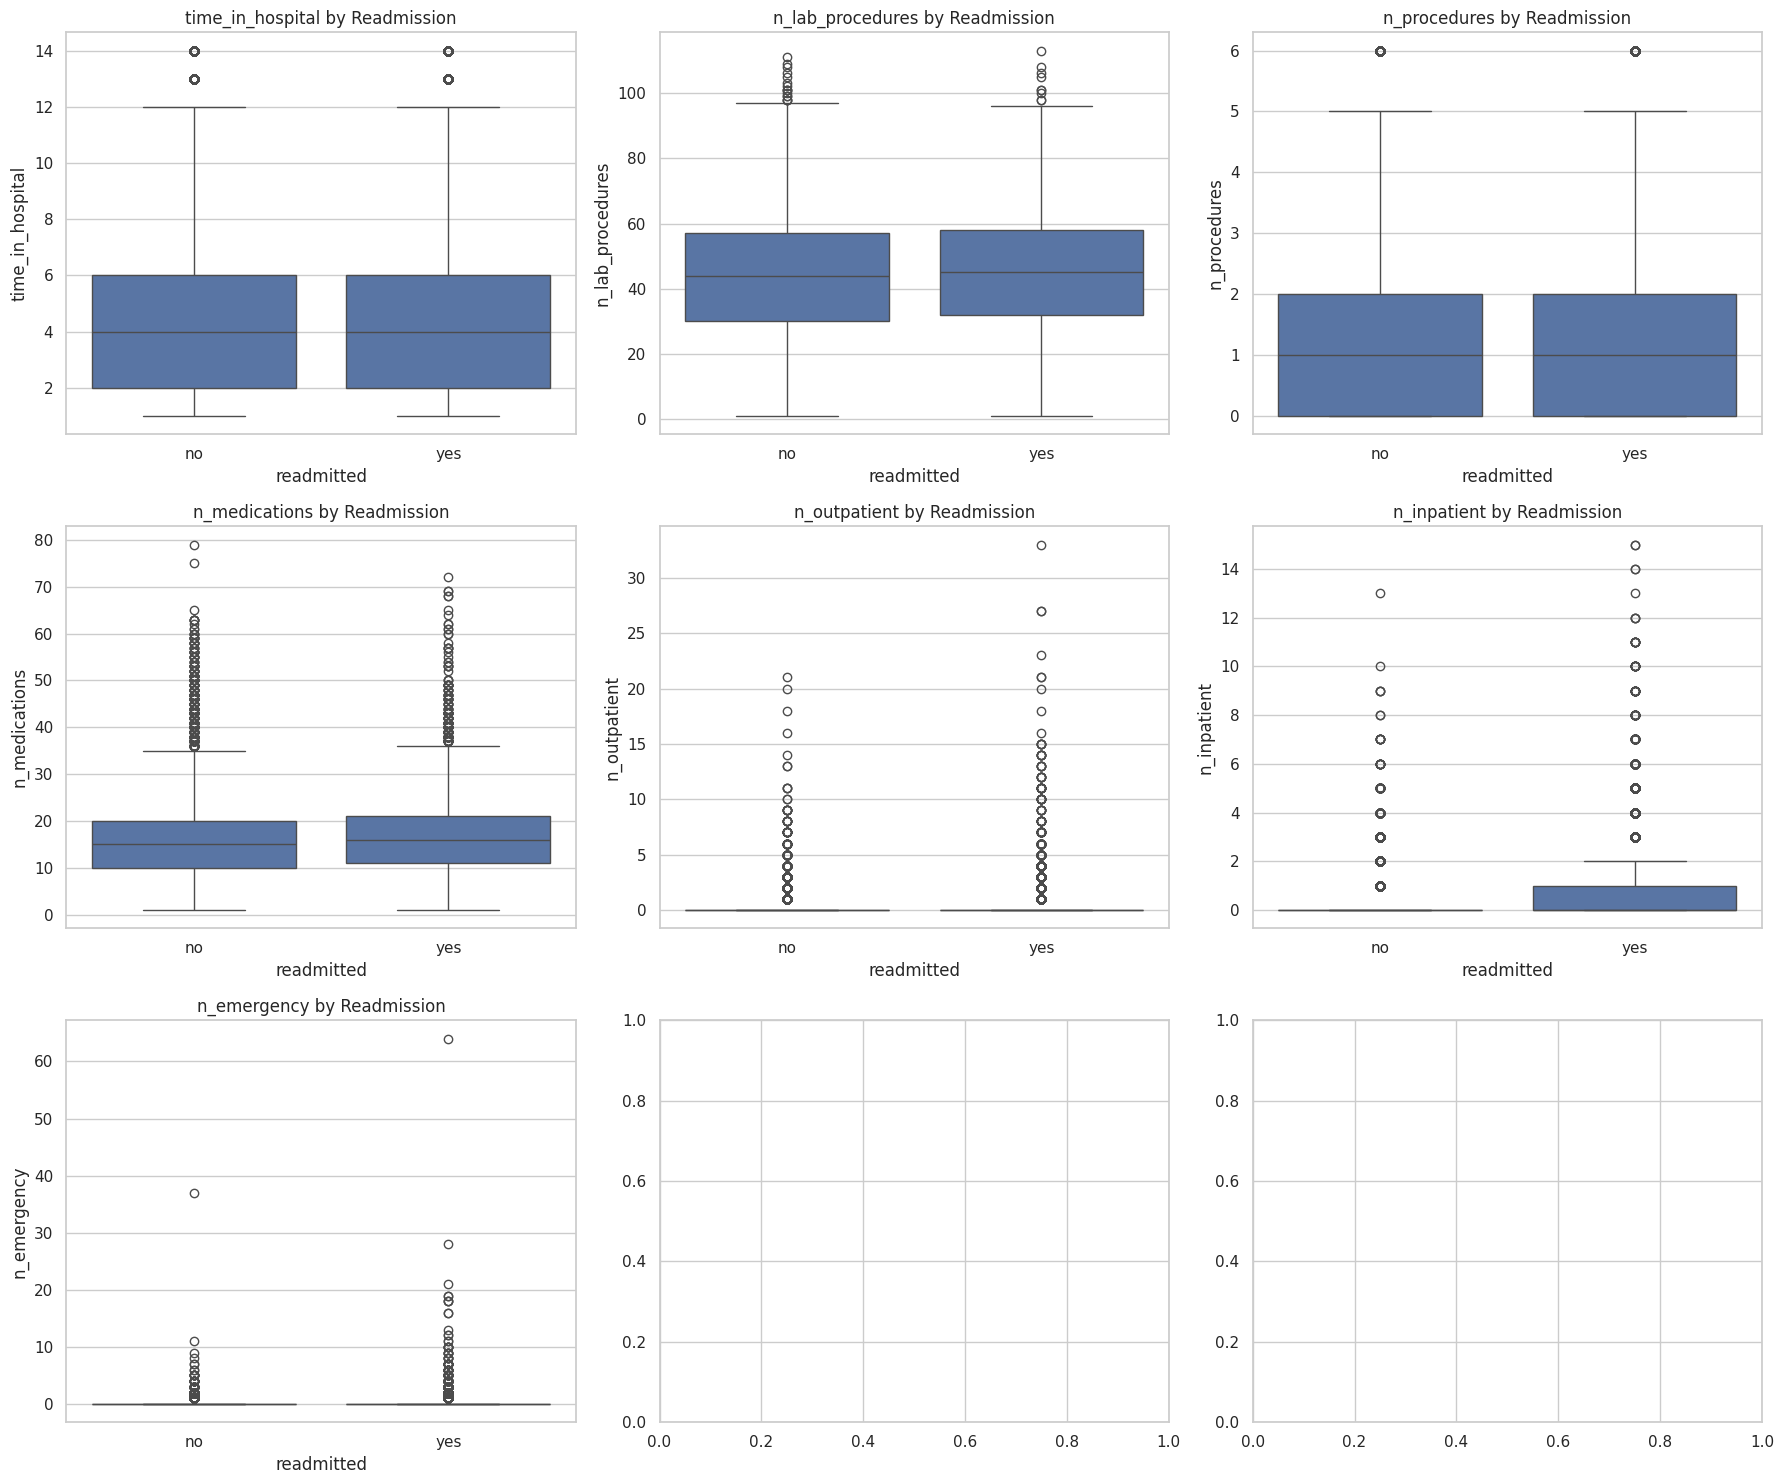

In [6]:
readmit_counts = df['readmitted'].value_counts()

fig2, axs2 = plt.subplots(3, 3, figsize=(18, 15))
for i, col in enumerate(numerical_cols):
    ax = axs2[i // 3, i % 3]
    sns.boxplot(x='readmitted', y=col, data=df, ax=ax)
    ax.set_title(f"{col} by Readmission")
plt.tight_layout()

Correlation Heatmap

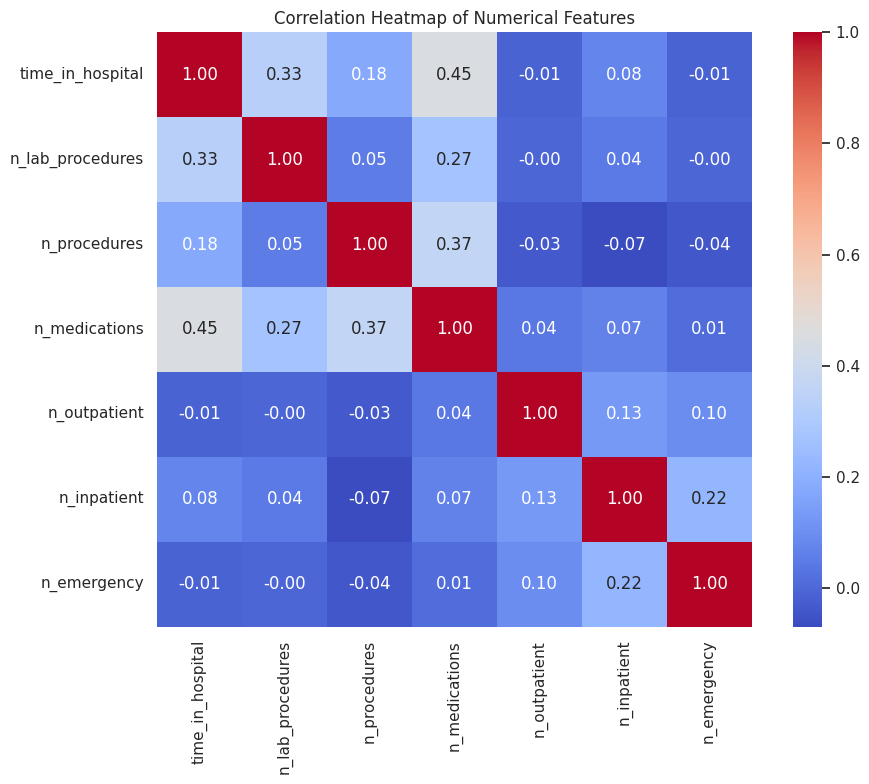

In [7]:
corr = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()


Categorical Feature Distribution

,Feature,Missing_Count


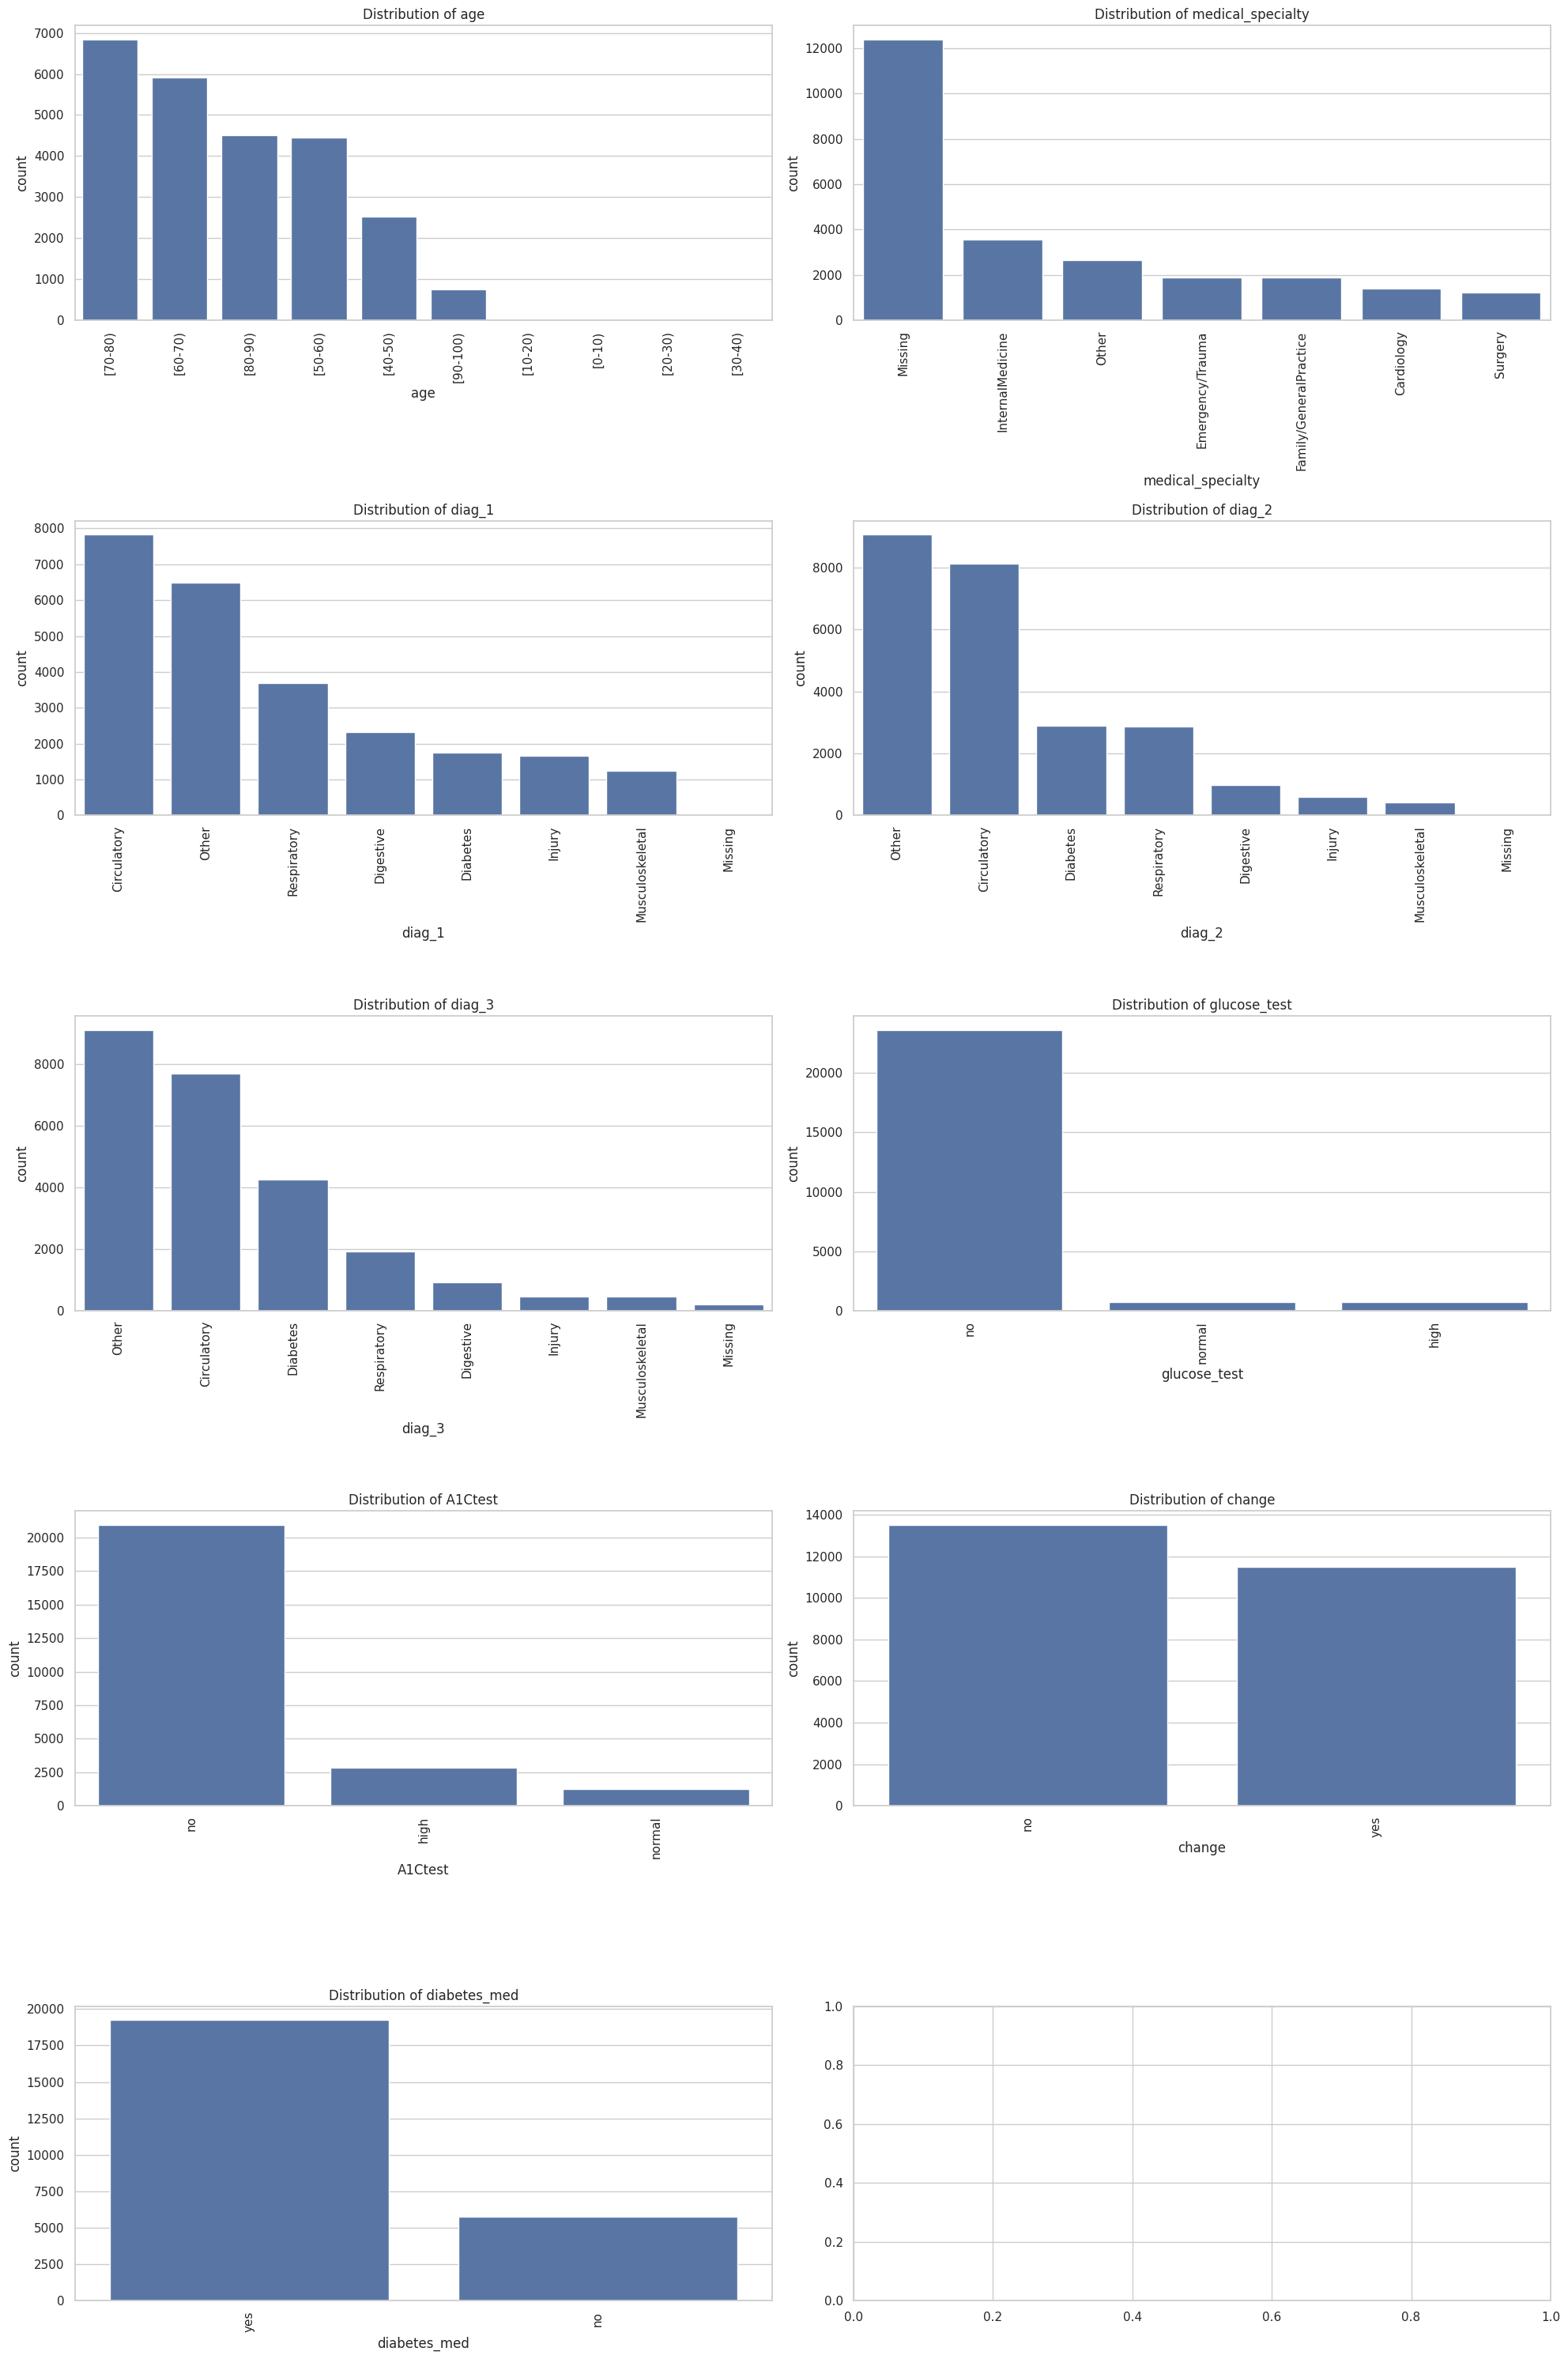

In [8]:
categorical_cols = ['age', 'medical_specialty', 'diag_1', 'diag_2',
                    'diag_3', 'glucose_test', 'A1Ctest', 'change',
                    'diabetes_med']

fig3, axs3 = plt.subplots(5, 2, figsize=(20, 30))
axs3 = axs3.flatten()
for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axs3[i])
    axs3[i].set_title(f"Distribution of {col}")
    axs3[i].tick_params(axis='x', rotation=90)
plt.tight_layout()

missing_values_df = missing_values[missing_values > 0].reset_index()
missing_values_df.columns = ['Feature', 'Missing_Count']
missing_values_df

Diagnosis Distribution

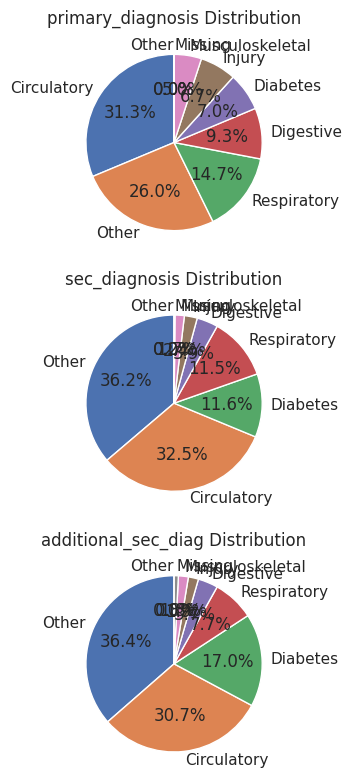

In [9]:
df = df.rename(columns={'diag_1': 'primary_diagnosis', 'diag_2': 'sec_diagnosis', 'diag_3': 'additional_sec_diag'})

cat_vars = ['primary_diagnosis', 'sec_diagnosis', 'additional_sec_diag']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 8))

for i, var in enumerate(cat_vars):
    if i < len(axs.flat):
        # Grouping rare values under 'Other' to make pie chart readable
        value_counts = df[var].value_counts()
        top_categories = value_counts[:10]
        other_count = value_counts[10:].sum()
        final_counts = pd.concat([top_categories, pd.Series({'Other': other_count})])

        axs.flat[i].pie(final_counts, labels=final_counts.index, autopct='%1.1f%%', startangle=90)
        axs.flat[i].set_title(f'{var} Distribution')

fig.tight_layout()
plt.show()

# **ML MODEL**

In [10]:
df = pd.read_csv("hospital_readmissions.csv")

df = df.rename(columns={
    'diag_1': 'primary_diagnosis',
    'diag_2': 'sec_diagnosis',
    'diag_3': 'additional_sec_diag'
})

df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,primary_diagnosis,sec_diagnosis,additional_sec_diag,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


### **Feature Engineering**

age bracketing


In [11]:
print(df['age'].unique())

age_map = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}

df['age_numeric'] = df['age'].map(age_map)

df['age_bracket'] = pd.cut(df['age_numeric'], bins=[0, 30, 50, 70, 100], labels=['0-30', '31-50', '51-70', '70+'])
print(df[['age', 'age_numeric', 'age_bracket']].head())

['[70-80)' '[50-60)' '[60-70)' '[40-50)' '[80-90)' '[90-100)']
       age  age_numeric age_bracket
0  [70-80)           75         70+
1  [70-80)           75         70+
2  [50-60)           55       51-70
3  [70-80)           75         70+
4  [60-70)           65       51-70


Diagnosis Code Mapping (ICD code to disease category)

In [12]:
def map_diagnosis(code):
    try:
        code = float(code)
        if 390 <= code <= 459 or code == 785:
            return 'Circulatory'
        elif 460 <= code <= 519 or code == 786:
            return 'Respiratory'
        elif 520 <= code <= 579 or code == 787:
            return 'Digestive'
        elif 250 <= code < 251:
            return 'Diabetes'
        elif 800 <= code <= 999:
            return 'Injury'
        elif 710 <= code <= 739:
            return 'Musculoskeletal'
        else:
            return 'Other'
    except:
        return 'Other'

df['primary_diagnosis'] = df['primary_diagnosis'].apply(map_diagnosis)
df['sec_diagnosis'] = df['sec_diagnosis'].apply(map_diagnosis)

Encode Tests and Medication Fields

In [13]:
binary_map = {'yes': 1, 'no': 0}
glucose_map = {'no': 0, 'normal': 1, 'high': 2}

df['change'] = df['change'].map(binary_map)
df['diabetes_med'] = df['diabetes_med'].map(binary_map)
df['glucose_test'] = df['glucose_test'].map(glucose_map)
df['A1Ctest'] = df['A1Ctest'].map(glucose_map)

Drop & Select Features

In [14]:
df = df.drop(['n_outpatient', 'additional_sec_diag'], axis=1)

features = [
    'age_bracket', 'time_in_hospital', 'n_procedures', 'n_lab_procedures',
    'n_medications', 'n_inpatient', 'n_emergency', 'medical_specialty',
    'primary_diagnosis', 'sec_diagnosis', 'glucose_test', 'A1Ctest',
    'change', 'diabetes_med'
]
target = 'readmitted'
df[features + [target]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age_bracket        25000 non-null  category
 1   time_in_hospital   25000 non-null  int64   
 2   n_procedures       25000 non-null  int64   
 3   n_lab_procedures   25000 non-null  int64   
 4   n_medications      25000 non-null  int64   
 5   n_inpatient        25000 non-null  int64   
 6   n_emergency        25000 non-null  int64   
 7   medical_specialty  25000 non-null  object  
 8   primary_diagnosis  25000 non-null  object  
 9   sec_diagnosis      25000 non-null  object  
 10  glucose_test       25000 non-null  int64   
 11  A1Ctest            25000 non-null  int64   
 12  change             25000 non-null  int64   
 13  diabetes_med       25000 non-null  int64   
 14  readmitted         25000 non-null  object  
dtypes: category(1), int64(10), object(4)
memory usage: 2.

### **Preprocessing (Encoding)**

In [15]:
df = df.dropna(subset=[target])
le = LabelEncoder()
for col in ['age_bracket', 'medical_specialty', 'primary_diagnosis', 'sec_diagnosis', target]:
    df[col] = le.fit_transform(df[col].astype(str))

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### **Train ML algorithms**

In [16]:
# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

# 3. Support Vector Machine
svm = SVC()
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
print("Support Vector Machine:\n", classification_report(y_test, y_pred_svm))

# 4. K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
print("K-Nearest Neighbors:\n", classification_report(y_test, y_pred_knn))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.60      0.80      0.68      2658
           1       0.63      0.39      0.48      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.59      0.58      5000
weighted avg       0.61      0.61      0.59      5000

Random Forest:
               precision    recall  f1-score   support

           0       0.60      0.63      0.61      2658
           1       0.55      0.51      0.53      2342

    accuracy                           0.58      5000
   macro avg       0.57      0.57      0.57      5000
weighted avg       0.57      0.58      0.57      5000

Support Vector Machine:
               precision    recall  f1-score   support

           0       0.61      0.75      0.67      2658
           1       0.62      0.45      0.52      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.60      0.60      5000
weighted av


 Logistic Regression Accuracy: 0.6062
 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.80      0.68      2658
           1       0.63      0.39      0.48      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.59      0.58      5000
weighted avg       0.61      0.61      0.59      5000


 Random Forest Accuracy: 0.5764
 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61      2658
           1       0.55      0.51      0.53      2342

    accuracy                           0.58      5000
   macro avg       0.57      0.57      0.57      5000
weighted avg       0.57      0.58      0.57      5000


 Support Vector Machine Accuracy: 0.6110
 Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.75      0.67     

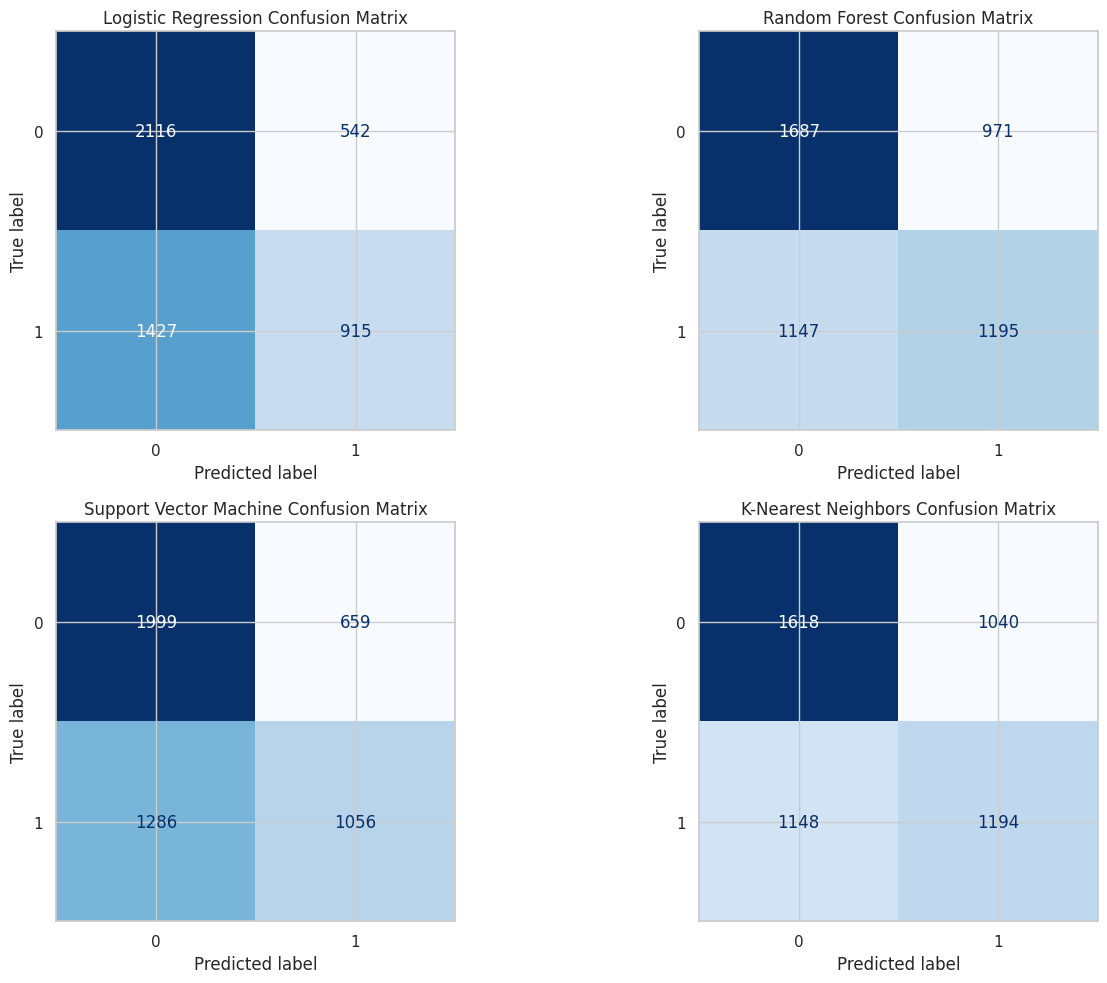

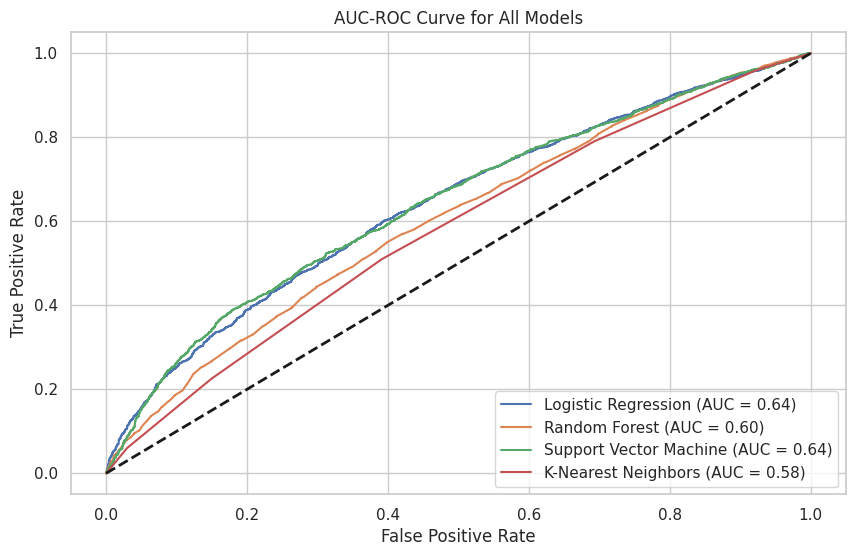

<ipython-input-17-0fc16b0e994a>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='coolwarm')


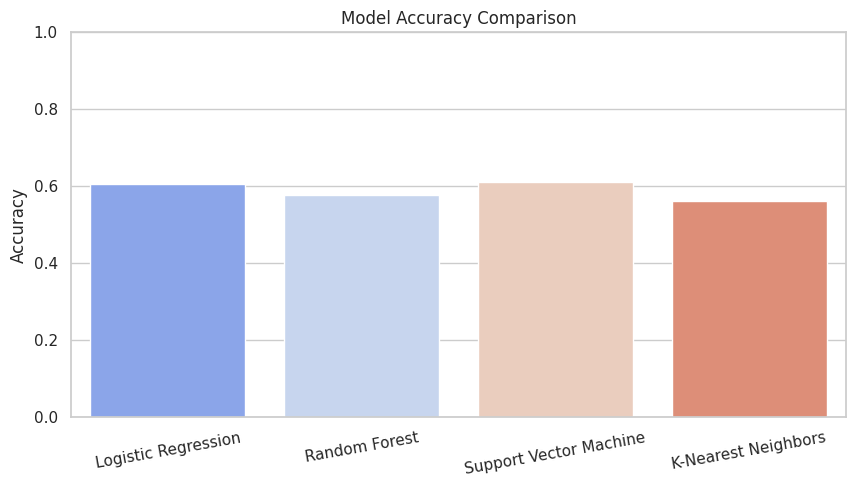


Final Predictive Analysis Conclusion:
The best performing model for hospital readmission prediction is Support Vector Machine,
with an accuracy of 0.61 on the test data.


In [17]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    classification_report, roc_curve, auc, RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dictionary of models and their predictions
models = {
    "Logistic Regression": (lr, y_pred_lr, lr.predict_proba(X_test_scaled)[:, 1]),
    "Random Forest": (rf, y_pred_rf, rf.predict_proba(X_test)[:, 1]),
    "Support Vector Machine": (svm, y_pred_svm, svm.decision_function(X_test_scaled)),
    "K-Nearest Neighbors": (knn, y_pred_knn, knn.predict_proba(X_test_scaled)[:, 1])
}

# Initialize figure for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
accuracies = {}

# Plot confusion matrix and collect accuracy for each model
for i, (model_name, (model_obj, y_pred, y_score)) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(f"{model_name} Confusion Matrix")

    acc = accuracy_score(y_test, y_pred)
    accuracies[model_name] = acc
    print(f"\n {model_name} Accuracy: {acc:.4f}")
    print(f" {model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

plt.tight_layout()
plt.show()

# ROC Curve Plotting
plt.figure(figsize=(10, 6))
for model_name, (_, _, y_score) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('AUC-ROC Curve for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot accuracy comparison bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='coolwarm')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=10)
plt.show()

# Final analysis print
best_model = max(accuracies, key=accuracies.get)
print(f"\nFinal Predictive Analysis Conclusion:")
print(f"The best performing model for hospital readmission prediction is {best_model},")
print(f"with an accuracy of {accuracies[best_model]:.2f} on the test data.")


In [18]:
!pip install imbalanced-learn

### **ACTUAL MODEL - increased accuracy wala model**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Logistic Regression Accuracy: 0.6068
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.73      0.66      2658
           1       0.60      0.46      0.52      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.60      0.59      5000
weighted avg       0.61      0.61      0.60      5000


Random Forest Accuracy: 0.5764
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61      2658
           1       0.55      0.51      0.53      2342

    accuracy                           0.58      5000
   macro avg       0.57      0.57      0.57      5000
weighted avg       0.57      0.58      0.57      5000


Support Vector Machine Accuracy: 0.6116
Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      2658


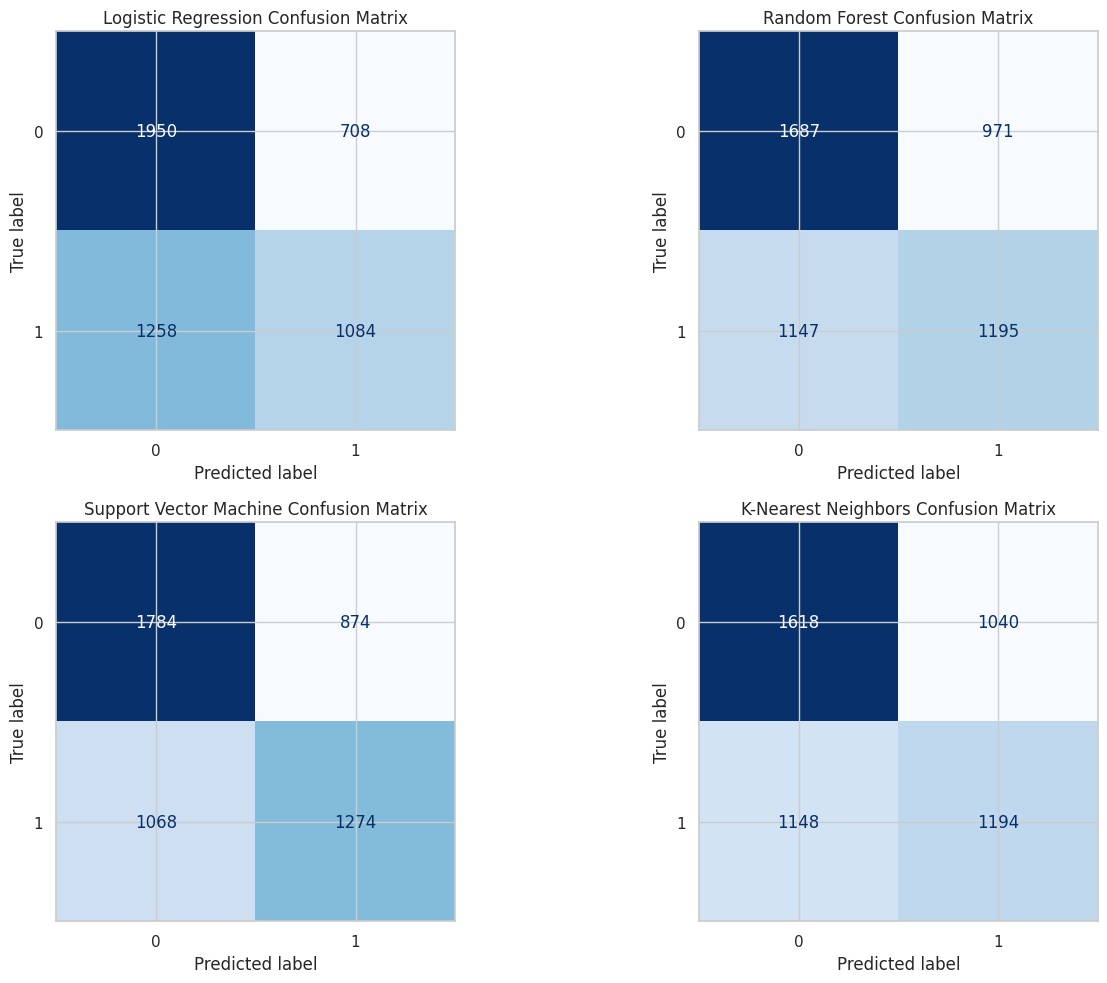

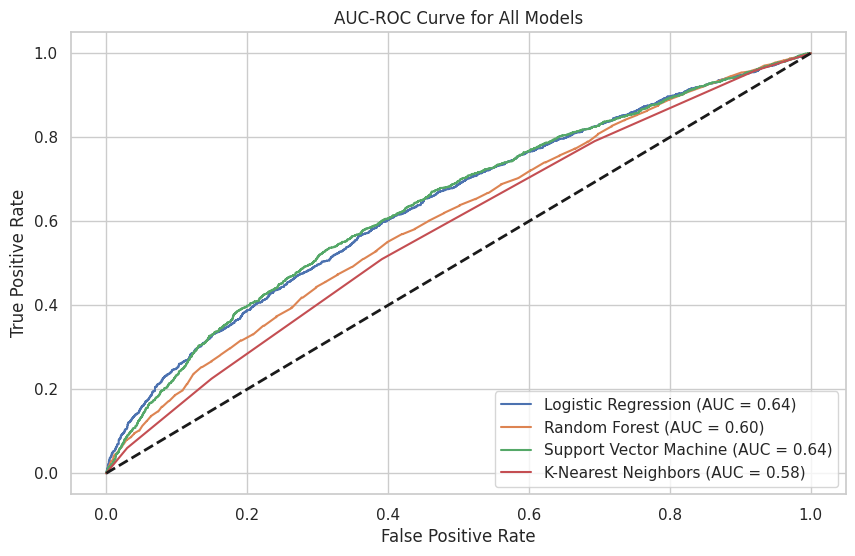

<ipython-input-23-939aec3c30bb>:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='coolwarm')


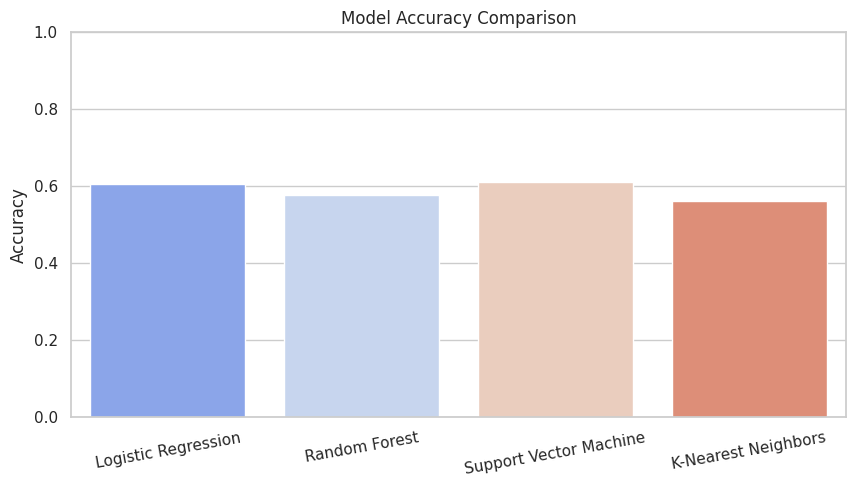


Final Predictive Analysis Conclusion:
The best performing model for hospital readmission prediction is Support Vector Machine,
with an accuracy of 0.61 on the test data.


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr.predict(X_test_scaled)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

svm = SVC(kernel='rbf', C=1.5, gamma='scale')
svm.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm.predict(X_test_scaled)
from joblib import dump
dump(svm, 'svm_model.joblib')
dump(scaler, 'scaler.joblib')
dump(le, 'label_encoder.joblib')

from google.colab import files
files.download('svm_model.joblib')
files.download('scaler.joblib')

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    classification_report, roc_curve, auc, RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "Logistic Regression": (lr, y_pred_lr, lr.predict_proba(X_test_scaled)[:, 1]),
    "Random Forest": (rf, y_pred_rf, rf.predict_proba(X_test)[:, 1]),
    "Support Vector Machine": (svm, y_pred_svm, svm.decision_function(X_test_scaled)),
    "K-Nearest Neighbors": (knn, y_pred_knn, knn.predict_proba(X_test_scaled)[:, 1])
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
accuracies = {}

for i, (model_name, (model_obj, y_pred, y_score)) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(f"{model_name} Confusion Matrix")

    acc = accuracy_score(y_test, y_pred)
    accuracies[model_name] = acc
    print(f"\n{model_name} Accuracy: {acc:.4f}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for model_name, (_, _, y_score) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('AUC-ROC Curve for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='coolwarm')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=10)
plt.show()

best_model = max(accuracies, key=accuracies.get)
print(f"\nFinal Predictive Analysis Conclusion:")
print(f"The best performing model for hospital readmission prediction is {best_model},")
print(f"with an accuracy of {accuracies[best_model]:.2f} on the test data.")


### **DATA ANALYTICS**

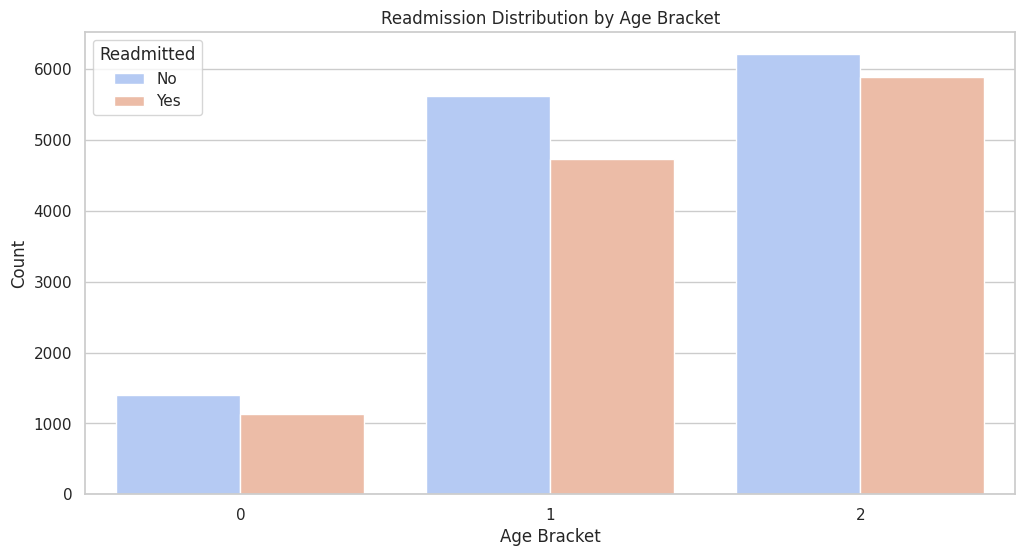

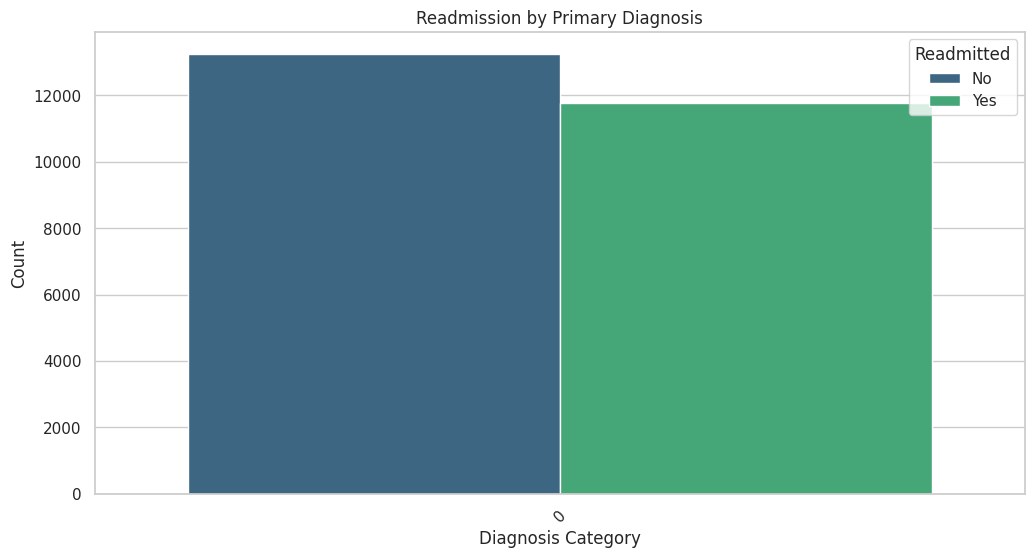

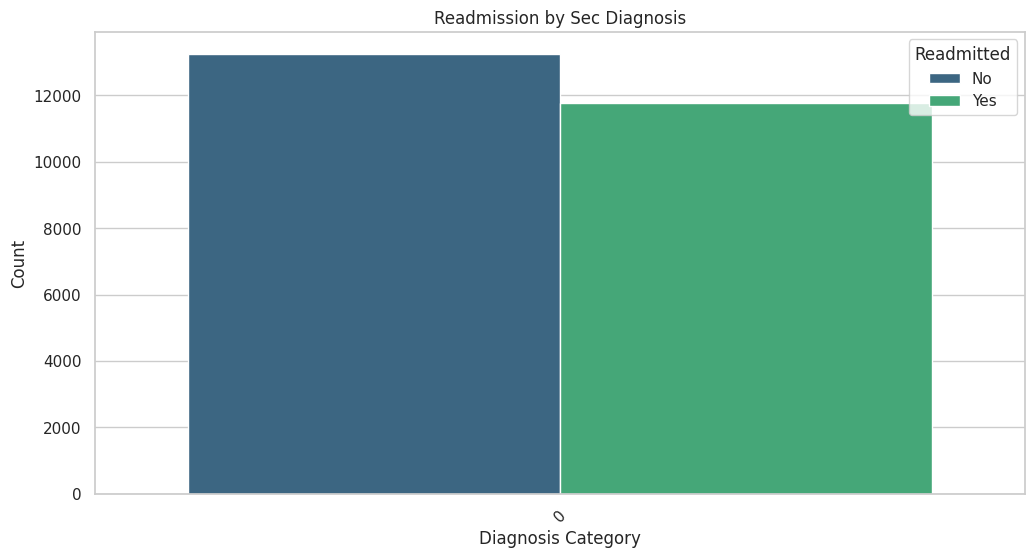

<ipython-input-22-ffc897a2c693>:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='age_bracket', y='readmitted', hue=feature,


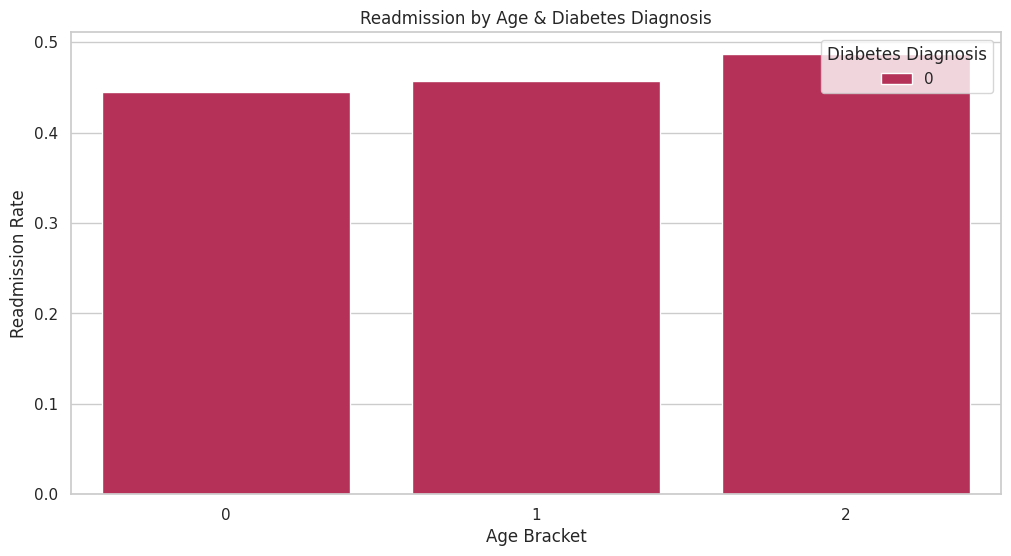

<ipython-input-22-ffc897a2c693>:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='age_bracket', y='readmitted', hue=feature,


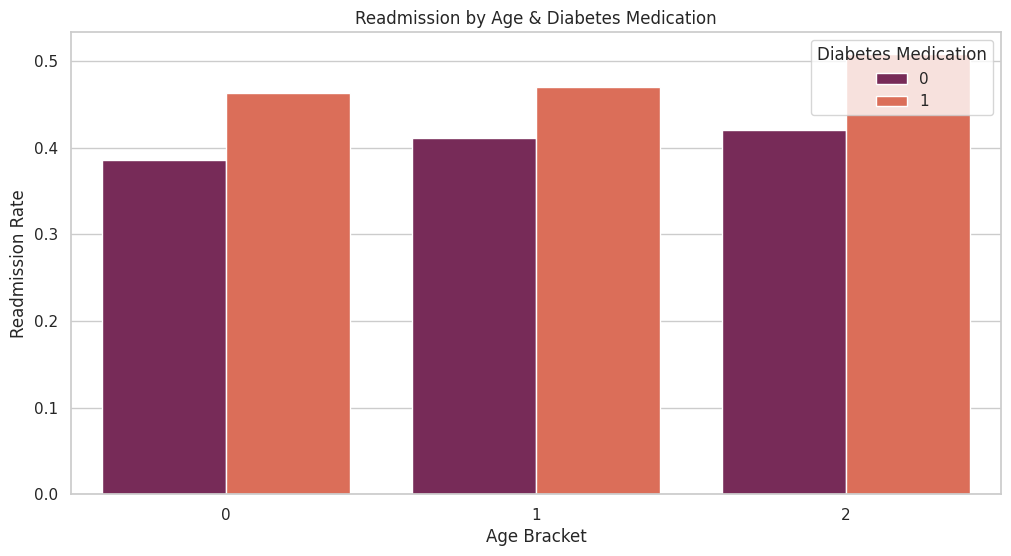

<ipython-input-22-ffc897a2c693>:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='age_bracket', y='readmitted', hue=feature,


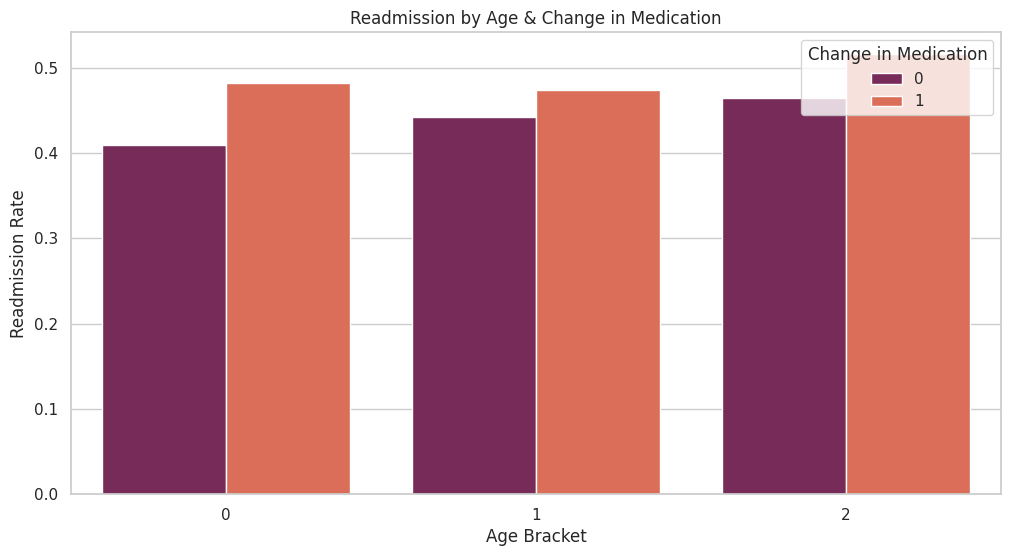

<ipython-input-22-ffc897a2c693>:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='age_bracket', y='readmitted', hue=feature,


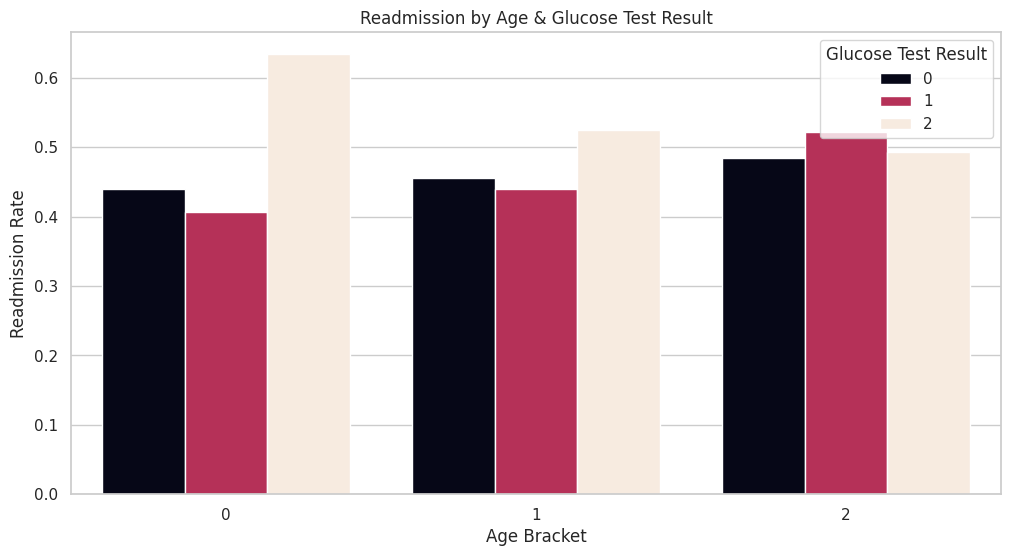

<ipython-input-22-ffc897a2c693>:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='age_bracket', y='readmitted', hue=feature,


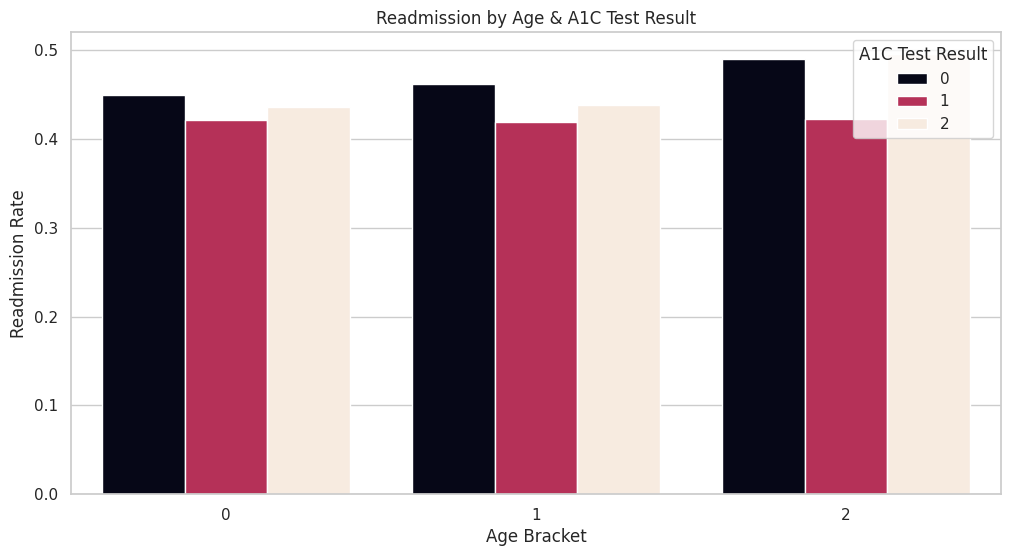

<ipython-input-22-ffc897a2c693>:80: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=f'{var}_bucket', y='readmitted', hue='diabetes_med',


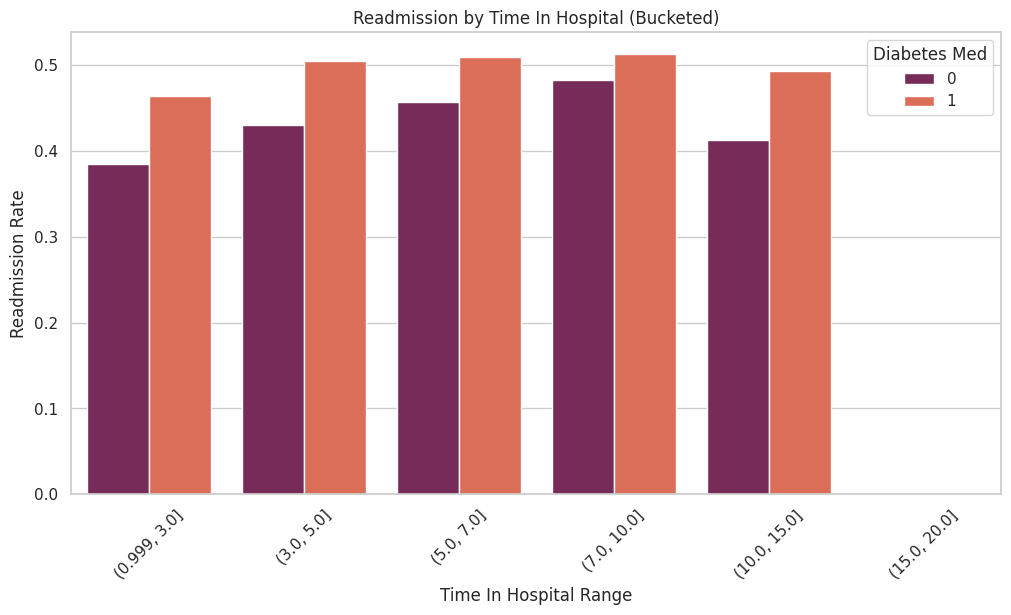

<ipython-input-22-ffc897a2c693>:80: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=f'{var}_bucket', y='readmitted', hue='diabetes_med',


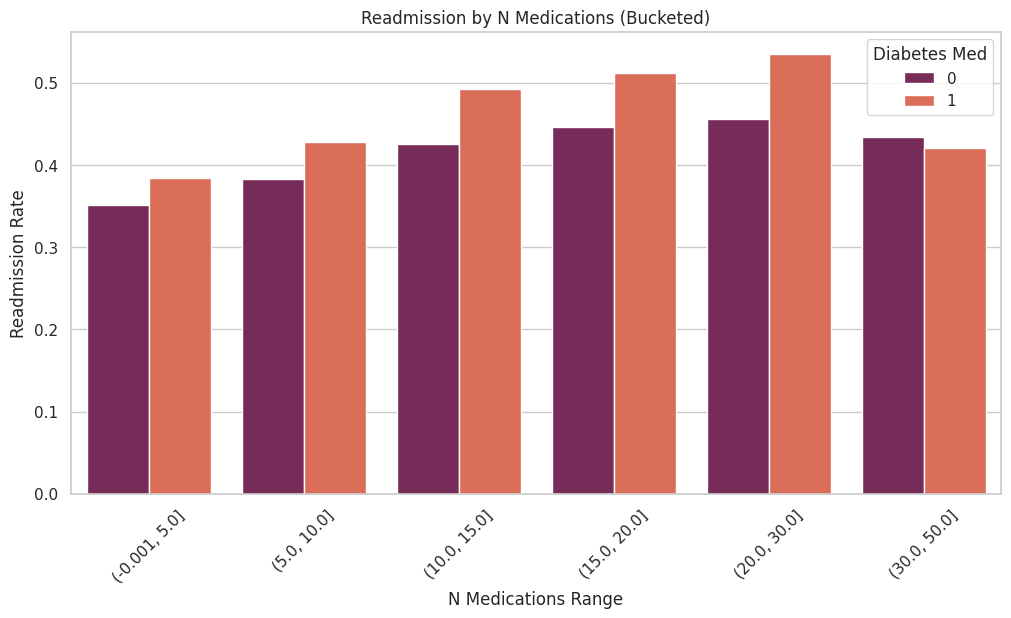

<ipython-input-22-ffc897a2c693>:80: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=f'{var}_bucket', y='readmitted', hue='diabetes_med',


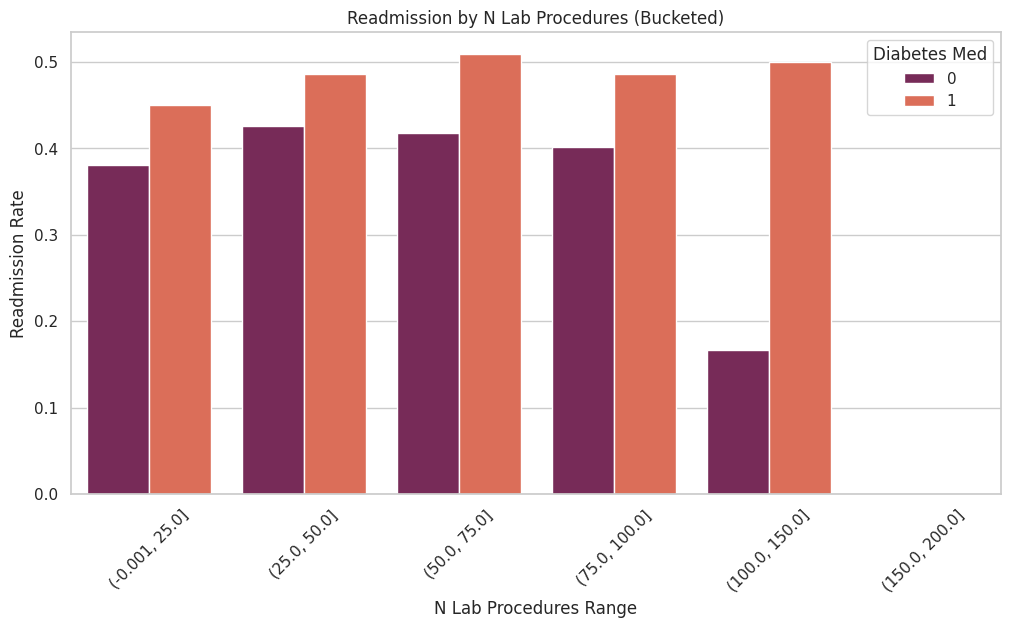

<ipython-input-22-ffc897a2c693>:80: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=f'{var}_bucket', y='readmitted', hue='diabetes_med',


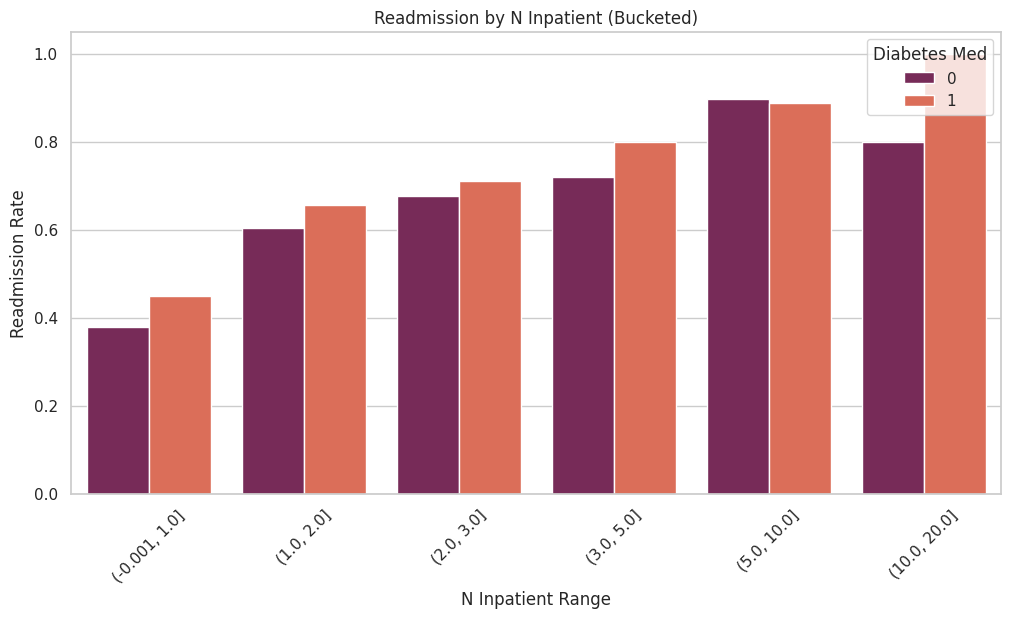

<ipython-input-22-ffc897a2c693>:80: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=f'{var}_bucket', y='readmitted', hue='diabetes_med',


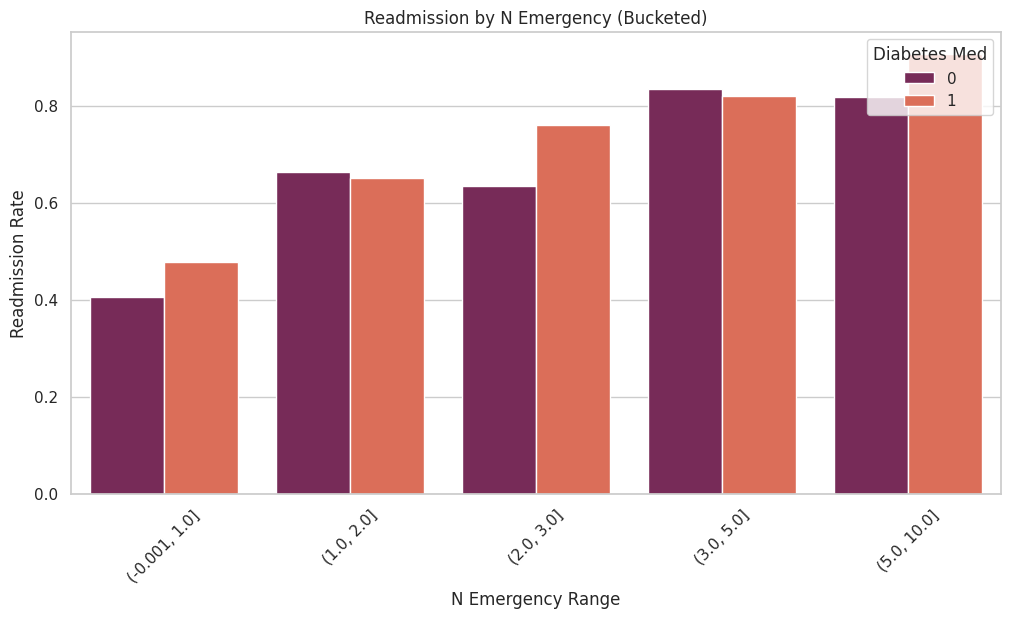


=== STATISTICAL SIGNIFICANCE TESTS ===


T-tests for Diabetes Diagnosis:

Age 0:
  Non-diabetic count: 2532
  Diabetic count: 0
  No diabetic patients in this age group

Age 1:
  Non-diabetic count: 10365
  Diabetic count: 0
  No diabetic patients in this age group

Age 2:
  Non-diabetic count: 12103
  Diabetic count: 0
  No diabetic patients in this age group


T-tests for Diabetes Medication:

Age 0:
  No meds count: 596
  With meds count: 1936
  No meds readmit rate: 38.59%
  With meds readmit rate: 46.33%
  p-value: 0.0009
  Significant

Age 1:
  No meds count: 2239
  With meds count: 8126
  No meds readmit rate: 41.13%
  With meds readmit rate: 46.95%
  p-value: 0.0000
  Significant

Age 2:
  No meds count: 2937
  With meds count: 9166
  No meds readmit rate: 42.08%
  With meds readmit rate: 50.79%
  p-value: 0.0000
  Significant


<ipython-input-22-ffc897a2c693>:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')


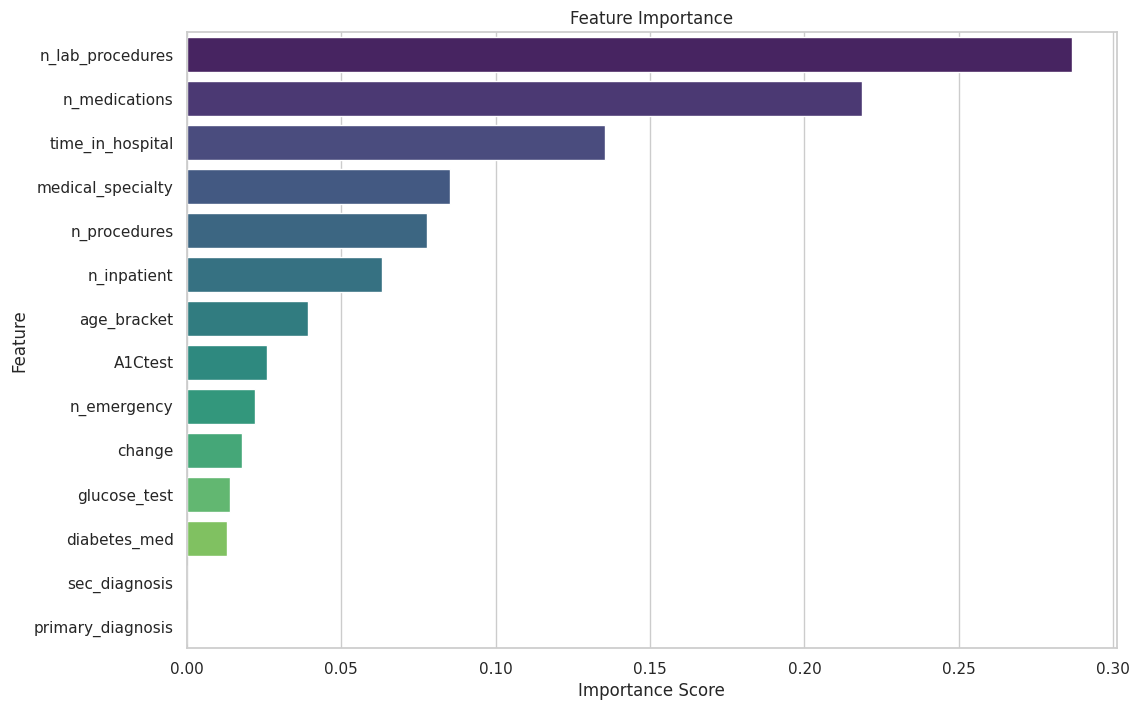


=== DETAILED MODEL PERFORMANCE ===


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.73      0.66      2658
           1       0.60      0.46      0.52      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.60      0.59      5000
weighted avg       0.61      0.61      0.60      5000



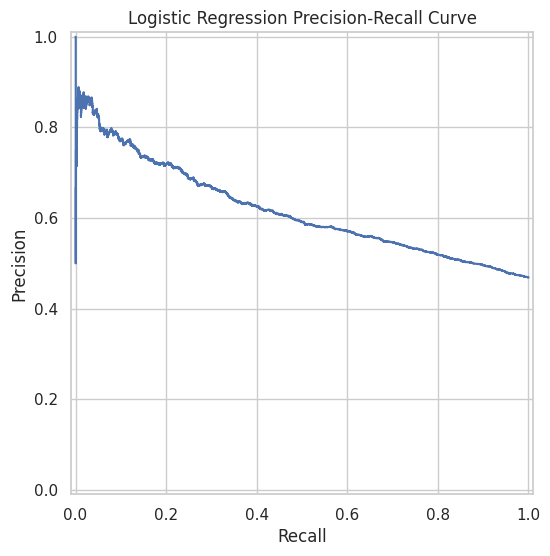


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61      2658
           1       0.55      0.51      0.53      2342

    accuracy                           0.58      5000
   macro avg       0.57      0.57      0.57      5000
weighted avg       0.57      0.58      0.57      5000



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


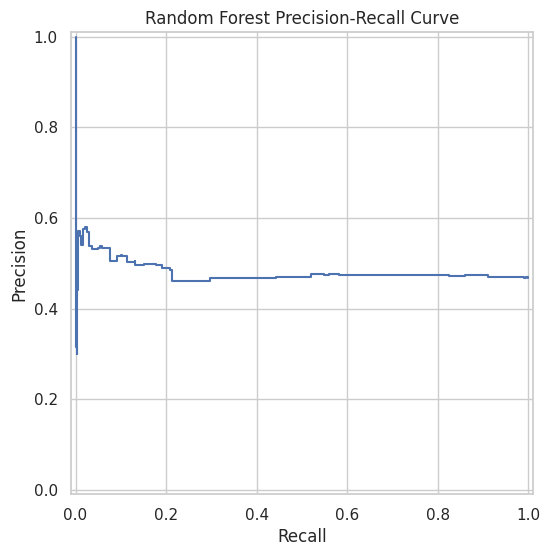


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      2658
           1       0.59      0.54      0.57      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000



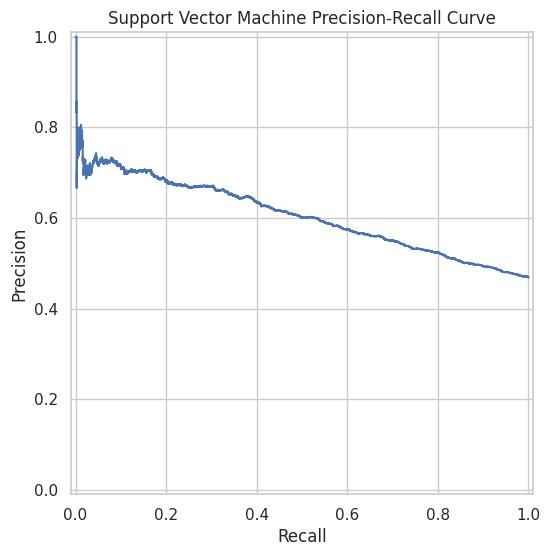


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.61      0.60      2658
           1       0.53      0.51      0.52      2342

    accuracy                           0.56      5000
   macro avg       0.56      0.56      0.56      5000
weighted avg       0.56      0.56      0.56      5000



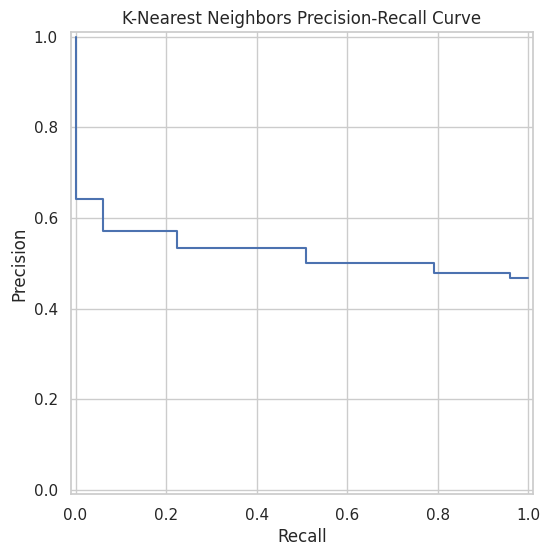

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='age_bracket', hue='readmitted', palette='coolwarm')
plt.title('Readmission Distribution by Age Bracket')
plt.xlabel('Age Bracket')
plt.ylabel('Count')
plt.legend(title='Readmitted', labels=['No', 'Yes'])
plt.show()

for diag_col in ['primary_diagnosis', 'sec_diagnosis']:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=diag_col, hue='readmitted', palette='viridis')
    plt.title(f'Readmission by {diag_col.replace("_", " ").title()}')
    plt.xlabel('Diagnosis Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Readmitted', labels=['No', 'Yes'])
    plt.show()

df['Diabetes_ind'] = ((df['primary_diagnosis'] == 'Diabetes') |
                      (df['sec_diagnosis'] == 'Diabetes')).astype(int)

diabetes_features = {
    'Diabetes_ind': 'Diabetes Diagnosis',
    'diabetes_med': 'Diabetes Medication',
    'change': 'Change in Medication',
    'glucose_test': 'Glucose Test Result',
    'A1Ctest': 'A1C Test Result'
}

for feature, title in diabetes_features.items():
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='age_bracket', y='readmitted', hue=feature,
                palette='rocket', ci=None)
    plt.title(f'Readmission by Age & {title}')
    plt.xlabel('Age Bracket')
    plt.ylabel('Readmission Rate')
    plt.legend(title=title, loc='upper right')
    plt.show()

continuous_vars = {
    'time_in_hospital': [1, 3, 5, 7, 10, 15, 20],
    'n_medications': [0, 5, 10, 15, 20, 30, 50],
    'n_lab_procedures': [0, 25, 50, 75, 100, 150, 200],
    'n_inpatient': [0, 1, 2, 3, 5, 10, 20],
    'n_emergency': [0, 1, 2, 3, 5, 10]
}

for var, bins in continuous_vars.items():
    df[f'{var}_bucket'] = pd.cut(df[var], bins=bins, include_lowest=True)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x=f'{var}_bucket', y='readmitted', hue='diabetes_med',
                palette='rocket', ci=None)
    plt.title(f'Readmission by {var.replace("_", " ").title()} (Bucketed)')
    plt.xlabel(f'{var.replace("_", " ").title()} Range')
    plt.ylabel('Readmission Rate')
    plt.xticks(rotation=45)
    plt.legend(title='Diabetes Med', loc='upper right')
    plt.show()

print("\n=== STATISTICAL SIGNIFICANCE TESTS ===\n")

def safe_ttest(group1, group2, group1_name, group2_name):
    if len(group1) < 2 or len(group2) < 2:
        print(f"  Not enough samples ({len(group1)} vs {len(group2)}) for valid test")
        return None, None

    try:
        t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
        return t_stat, p_val
    except Exception as e:
        print(f"  Test failed: {str(e)}")
        return None, None

print("\nT-tests for Diabetes Diagnosis:")
for age_group in sorted(df['age_bracket'].unique()):
    non_diabetic = df[(df['Diabetes_ind'] == 0) & (df['age_bracket'] == age_group)]['readmitted']
    diabetic = df[(df['Diabetes_ind'] == 1) & (df['age_bracket'] == age_group)]['readmitted']

    print(f"\nAge {age_group}:")
    print(f"  Non-diabetic count: {len(non_diabetic)}")
    print(f"  Diabetic count: {len(diabetic)}")

    if len(diabetic) == 0:
        print("  No diabetic patients in this age group")
        continue

    print(f"  Non-diabetic readmit rate: {non_diabetic.mean():.2%}")
    print(f"  Diabetic readmit rate: {diabetic.mean():.2%}")

    t_stat, p_val = safe_ttest(non_diabetic, diabetic, "non-diabetic", "diabetic")

    if p_val is not None:
        print(f"  p-value: {p_val:.4f}")
        print("  " + ("Significant" if p_val < 0.05 else "Not significant"))

print("\n\nT-tests for Diabetes Medication:")
for age_group in sorted(df['age_bracket'].unique()):
    no_meds = df[(df['diabetes_med'] == 0) & (df['age_bracket'] == age_group)]['readmitted']
    with_meds = df[(df['diabetes_med'] == 1) & (df['age_bracket'] == age_group)]['readmitted']

    print(f"\nAge {age_group}:")
    print(f"  No meds count: {len(no_meds)}")
    print(f"  With meds count: {len(with_meds)}")

    if len(with_meds) == 0:
        print("  No patients with diabetes meds in this age group")
        continue

    print(f"  No meds readmit rate: {no_meds.mean():.2%}")
    print(f"  With meds readmit rate: {with_meds.mean():.2%}")

    t_stat, p_val = safe_ttest(no_meds, with_meds, "no meds", "with meds")

    if p_val is not None:
        print(f"  p-value: {p_val:.4f}")
        print("  " + ("Significant" if p_val < 0.05 else "Not significant"))

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

model_objects = {
    "Logistic Regression": (lr, y_pred_lr),
    "Random Forest": (rf, y_pred_rf),
    "Support Vector Machine": (svm, y_pred_svm),
    "K-Nearest Neighbors": (knn, y_pred_knn)
}

print("\n=== DETAILED MODEL PERFORMANCE ===\n")

for name, (model, preds) in model_objects.items():
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, preds))

    from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

    try:
        if name == "Support Vector Machine":
            probs = model.decision_function(X_test_scaled)
        else:
            probs = model.predict_proba(X_test_scaled)[:, 1]

        prec, recall, _ = precision_recall_curve(y_test, probs)
        disp = PrecisionRecallDisplay(precision=prec, recall=recall)
        disp.plot()
        plt.title(f'{name} Precision-Recall Curve')
        plt.show()

    except AttributeError as e:
        print(f"Could not generate Precision-Recall curve for {name}: {str(e)}")


### **USER INPUT TEST RUN**

=== HOSPITAL READMISSION PREDICTION (SVM MODEL) ===

=== HOSPITAL READMISSION RISK ASSESSMENT ===

[1/14] Age Bracket:
1. 0-30  2. 31-50  3. 51-70  4. 70+
Choice (1-4): 4

[2/14] Days in hospital (1-14): 13
[3/14] Number of procedures (0-6): 6
[4/14] Number of lab tests (1-132): 120

[5/14] Number of medications (1-81): 80
[6/14] Medication change? (1=No, 2=Yes): 2
[7/14] Diabetes medication? (1=No, 2=Yes): 1

[8/14] Inpatient visits last year (0-21): 20
[9/14] Emergency visits last year (0-76): 70

[10/14] Primary Diagnosis:
1.Circulatory 2.Respiratory 3.Digestive
4.Diabetes 5.Injury 6.Musculoskeletal 7.Other
Choice (1-7): 4

[11/14] Secondary Diagnosis:
1.Circulatory 2.Respiratory 3.Digestive
4.Diabetes 5.Injury 6.Musculoskeletal 7.Other
Choice (1-7): 6

[12/14] Glucose Test Results:
1.No test 2.Normal 3.High
Choice (1-3): 3

[13/14] A1C Test Results:
1.No test 2.Normal 3.High
Choice (1-3): 3

[14/14] Admitting Specialty:
1.Cardiology 2.InternalMedicine 3.FamilyPractice
4.Surgery 5.E

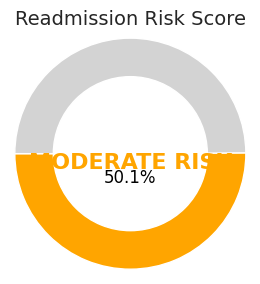


[WARNING] Moderate risk detected:
- Schedule follow-up within 7 days
- Review discharge medications


In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

try:
    svm_model = joblib.load('/content/svm_model.joblib')
    scaler = joblib.load('/content/scaler.joblib')
except FileNotFoundError:
    print("Error: Model files not found. Please train and save your model first.")
    exit()

FEATURE_ORDER = [
    'age_bracket', 'time_in_hospital', 'n_procedures', 'n_lab_procedures',
    'n_medications', 'n_inpatient', 'n_emergency', 'medical_specialty',
    'primary_diagnosis', 'sec_diagnosis', 'glucose_test', 'A1Ctest',
    'change', 'diabetes_med'
]

NUMERICAL_FEATURES = [
    'time_in_hospital', 'n_procedures', 'n_lab_procedures',
    'n_medications', 'n_inpatient', 'n_emergency'
]

def get_patient_input():
    """Collect all required patient information with validation"""
    print("\n=== HOSPITAL READMISSION RISK ASSESSMENT ===")
    data = {}

    print("\n[1/14] Age Bracket:")
    print("1. 0-30  2. 31-50  3. 51-70  4. 70+")
    data['age_bracket'] = int(input("Choice (1-4): ")) - 1

    data['time_in_hospital'] = int(input("\n[2/14] Days in hospital (1-14): "))
    data['n_procedures'] = int(input("[3/14] Number of procedures (0-6): "))
    data['n_lab_procedures'] = int(input("[4/14] Number of lab tests (1-132): "))

    data['n_medications'] = int(input("\n[5/14] Number of medications (1-81): "))
    data['change'] = int(input("[6/14] Medication change? (1=No, 2=Yes): ")) - 1
    data['diabetes_med'] = int(input("[7/14] Diabetes medication? (1=No, 2=Yes): ")) - 1

    data['n_inpatient'] = int(input("\n[8/14] Inpatient visits last year (0-21): "))
    data['n_emergency'] = int(input("[9/14] Emergency visits last year (0-76): "))

    print("\n[10/14] Primary Diagnosis:")
    print("1.Circulatory 2.Respiratory 3.Digestive")
    print("4.Diabetes 5.Injury 6.Musculoskeletal 7.Other")
    data['primary_diagnosis'] = int(input("Choice (1-7): ")) - 1

    print("\n[11/14] Secondary Diagnosis:")
    print("1.Circulatory 2.Respiratory 3.Digestive")
    print("4.Diabetes 5.Injury 6.Musculoskeletal 7.Other")
    data['sec_diagnosis'] = int(input("Choice (1-7): ")) - 1

    print("\n[12/14] Glucose Test Results:")
    print("1.No test 2.Normal 3.High")
    data['glucose_test'] = int(input("Choice (1-3): ")) - 1

    print("\n[13/14] A1C Test Results:")
    print("1.No test 2.Normal 3.High")
    data['A1Ctest'] = int(input("Choice (1-3): ")) - 1

    print("\n[14/14] Admitting Specialty:")
    print("1.Cardiology 2.InternalMedicine 3.FamilyPractice")
    print("4.Surgery 5.Emergency 6.Other")
    data['medical_specialty'] = int(input("Choice (1-6): ")) - 1

    return data

def prepare_input(data_dict):
    input_df = pd.DataFrame([data_dict], columns=FEATURE_ORDER)
    input_scaled = scaler.transform(input_df)
    input_df = pd.DataFrame(input_scaled, columns=FEATURE_ORDER)
    return input_df.values

def predict_readmission(input_array):
    prediction = svm_model.predict(input_array)[0]
    confidence = svm_model.decision_function(input_array)[0]
    probability = 1 / (1 + np.exp(-confidence))
    return prediction, probability

def main():
    print("=== HOSPITAL READMISSION PREDICTION (SVM MODEL) ===")
    patient_data = get_patient_input()
    model_input = prepare_input(patient_data)
    try:
        prediction, probability = predict_readmission(model_input)

        print("\n=== PREDICTION RESULTS ===")
        print(f"Readmission Risk Score: {probability:.1%}")
        print("Prediction:", "HIGH RISK" if prediction == 1 else "LOW RISK")

        if probability > 0.7:
            print("\n[ACTION REQUIRED] High risk detected:")
            print("- Schedule follow-up within 3 days")
            print("- Medication reconciliation required")
            print("- Notify care coordinator")
        elif probability > 0.4:
            print("\n[WARNING] Moderate risk detected:")
            print("- Schedule follow-up within 7 days")
            print("- Review discharge medications")
        else:
            print("\n[LOW RISK] Standard discharge protocol")

    except Exception as e:
        print(f"\nError during prediction: {str(e)}")
        print("Please verify all input values are correct")

if __name__ == "__main__":
    main()